Реалізуємо задачу перенесення стилю (Neural Style Transfer) із використанням TensorFlow та Keras.

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Iteration 0, Loss: 1152459904.0
Iteration 50, Loss: 116033376.0
Iteration 100, Loss: 90235216.0
Iteration 150, Loss: 82248368.0
Iteration 200, Loss: 78928384.0
Iteration 250, Loss: 76305016.0
Iteration 300, Loss: 74707552.0
Iteration 350, Loss: 73605008.0
Iteration 400, Loss: 73580592.0
Iteration 450, Loss: 74967872.0


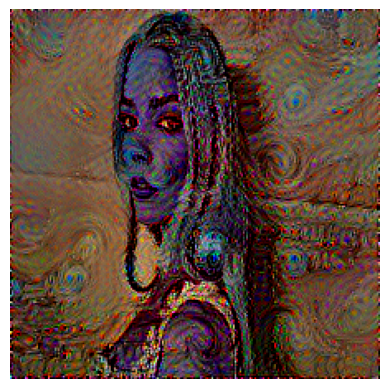

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# 1. Завантаження зображень
def load_and_process_img(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# 2. Візуалізація зображень
def show_img(img):
    img = img[0]  # Видалення зайвого виміру
    img = np.clip(img, 0, 255).astype("uint8")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 3. Розвантаження моделі VGG19
def get_vgg19_model():
    vgg = VGG19(weights='imagenet', include_top=False)
    outputs = [vgg.get_layer(name).output for name in ["block5_conv2", "block4_conv2", "block3_conv2", "block2_conv2"]]
    return Model([vgg.input], outputs)

# 4. Функція обчислення втрат стилю
def compute_style_loss(style, generated):
    style = gram_matrix(style)
    generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style - generated))

# 5. Функція обчислення втрат контенту
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# 6. Функція Грама для стилю
def gram_matrix(feature_map):
    channels = int(feature_map.shape[-1])
    a = tf.reshape(feature_map, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# 7. Оптимізація зображення
def train_step(model, content_img, style_img, generated_img, optimizer, style_weight=1e-2, content_weight=1e3):
    with tf.GradientTape() as tape:
        outputs = model(generated_img)
        content_outputs = model(content_img)
        style_outputs = model(style_img)

        # Розділення стилю і контенту
        content_loss = compute_content_loss(content_outputs[-1], outputs[-1])
        style_loss = tf.add_n([compute_style_loss(style_outputs[i], outputs[i]) for i in range(len(style_outputs))])

        # Загальні втрати
        total_loss = content_weight * content_loss + style_weight * style_loss

    grad = tape.gradient(total_loss, generated_img)
    optimizer.apply_gradients([(grad, generated_img)])
    generated_img.assign(tf.clip_by_value(generated_img, 0.0, 255.0))
    return total_loss

# 8. Генерація нового зображення
def style_transfer(content_path, style_path, iterations=500):
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)

    # Створення шумового зображення
    generated_img = tf.Variable(content_img, dtype=tf.float32)

    # Модель
    model = get_vgg19_model()
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    for i in range(iterations):
        loss = train_step(model, content_img, style_img, generated_img, optimizer)
        if i % 50 == 0:
            print(f"Iteration {i}, Loss: {loss.numpy()}")

    return generated_img

# Приклади зображень


content_path = '1.jpg'
style_path = '2.jpg'

# Виконання переносу стилю
generated_image = style_transfer(content_path, style_path)

# Відображення результату
show_img(generated_image)
